# Part 2, Model 2B: Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on the fundus, the optic cup, and the optic disk images of the eye + calculated OC feature + calculated OD feature using statistical analysis. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-02-25 14:14:41.473767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 14:14:41.473906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 14:14:41.476426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 14:14:41.489875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 14:14:42.639896: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# know column type
data['fundus_oc_seg'].dtype

dtype('O')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [9]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


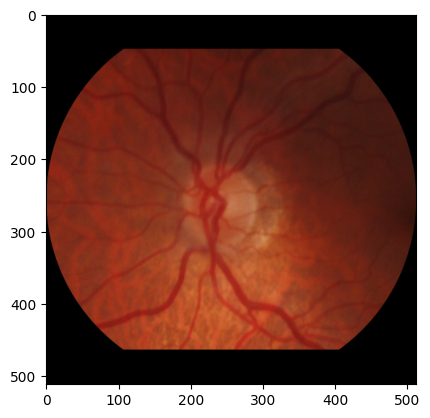

optic-cup/optic-cup/PAPILA-484.png


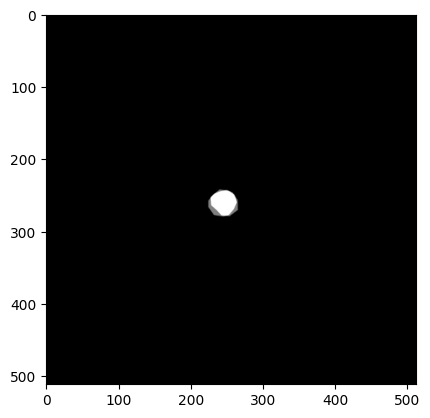

optic-disc/optic-disc/PAPILA-484.png


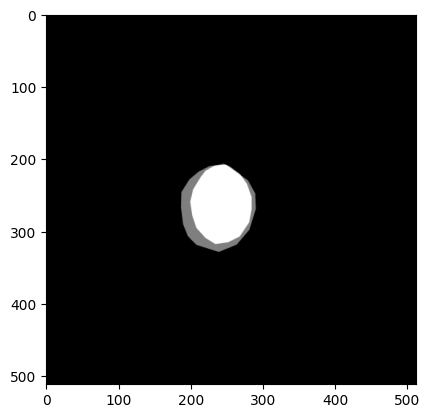

In [10]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])
viewOpticDisc(data['fundus_od_seg'][12044])

In [11]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data['eye'] = data['eye'].replace({'OD': 0, 'OS': 1})

data[['eye']].value_counts()

eye
1.0    2925
0.0    2808
Name: count, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Assuming 'data' is your original DataFrame

# Separate the data into numerical and non-numerical subsets
numerical_data = data.select_dtypes(include=[np.number])  # only numerical features

# Check and fill columns with all NaN values
for col in numerical_data.columns:
    if numerical_data[col].isna().all():
        numerical_data[col].fillna(0, inplace=True)  # or use another strategy

# Check the number of columns before imputation
print("Number of columns before imputation:", numerical_data.shape[1])

# Initialize the IterativeImputer with a RandomForestRegressor
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)

# Perform the imputation - fit and transform the numerical data
numerical_data_imputed = imp.fit_transform(numerical_data)

# Convert the imputed numerical data back to a pandas DataFrame
# Debugging: Check the shape of the imputed data
print("Shape of imputed data:", numerical_data_imputed.shape)

# Create the DataFrame using the original column names
# Here we're assuming that the columns should match the original
# If not, adjust the columns parameter accordingly
numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

# Combine the imputed numerical data back with the non-numerical data
non_numerical_data = data.select_dtypes(exclude=[np.number])  # reselect to include changes
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

# Ensure the order of rows remains the same
data_imputed = data_imputed.loc[data.index]

Number of columns before imputation: 25


Shape of imputed data: (12449, 25)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [15]:
print(data_imputed.describe())

              types  isColor        gender           age           eye  \
count  12449.000000  12449.0  12449.000000  12449.000000  12449.000000   
mean       0.372239      1.0      0.473443     58.118310      0.568238   
std        0.505039      0.0      0.496742      8.052161      0.495342   
min       -1.000000      1.0      0.000000      1.000000      0.000000   
25%        0.000000      1.0      0.000000     58.000000      0.000000   
50%        0.000000      1.0      0.000000     59.620000      1.000000   
75%        1.000000      1.0      1.000000     59.620000      1.000000   
max        1.000000      1.0      1.000000     91.000000      1.000000   

                sbp           dbp            hr           iop          vcdr  \
count  12449.000000  12449.000000  12449.000000  12449.000000  12449.000000   
mean     174.154728     80.850432     62.785357     15.560491      0.589701   
std       58.491253      3.534565      5.951710      3.308625      0.090000   
min      107.0000

In [16]:
data_imputed[["eye"]].value_counts()

eye
1.0    7074
0.0    5375
Name: count, dtype: int64

In [17]:
data_imputed['eye'] = data_imputed['eye'].round().astype(int)

In [18]:
data_imputed[["eye"]].value_counts()

eye
1      7074
0      5375
Name: count, dtype: int64

In [19]:
data = data_imputed

data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,0.0,1.0,1.0,58.0,0,272.83,83.44,66.66,19.22,0.570579,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,0.0,60.0,1,127.76,79.32,56.46,13.08,0.660272,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,1.0,66.0,1,144.58,80.00,56.86,13.43,0.516117,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,1.0,0.0,70.0,0,168.34,79.20,58.34,19.04,0.421169,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,0.0,45.0,1,151.73,80.02,63.59,18.86,0.676515,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0.0,1.0,1.0,58.0,0,272.83,83.50,66.60,19.22,0.559863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0.0,1.0,1.0,58.0,0,272.83,83.50,66.60,19.22,0.559863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0.0,1.0,1.0,58.0,0,272.83,83.50,66.60,19.22,0.559863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0.0,1.0,1.0,58.0,0,272.83,83.50,66.60,19.22,0.559863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data[["age"]].value_counts()

age      
59.620000    4116
58.000000    2678
56.000000     240
54.000000     212
60.000000     206
             ... 
31.795559       1
61.010000       1
31.777845       1
49.010000       1
91.000000       1
Name: count, Length: 341, dtype: int64

optic-cup/optic-cup/PAPILA-484.png
optic-cup/optic-cup/PAPILA-484.png


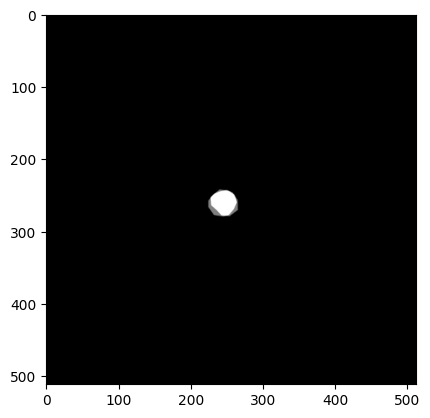

Normalized OC Area: 0.004856109619140625


In [21]:
import cv2
import numpy as np

def compute_normalized_area_optic_cup(masked_image_path):

    try:

        masked_image_path = 'optic-cup' + masked_image_path

        print(masked_image_path)


        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_cup(data['fundus_oc_seg'][12044])

viewOpticCup(data['fundus_oc_seg'][12044])

print(f"Normalized OC Area: {normalized_area}")

optic-disc/optic-disc/PAPILA-484.png
optic-disc/optic-disc/PAPILA-484.png


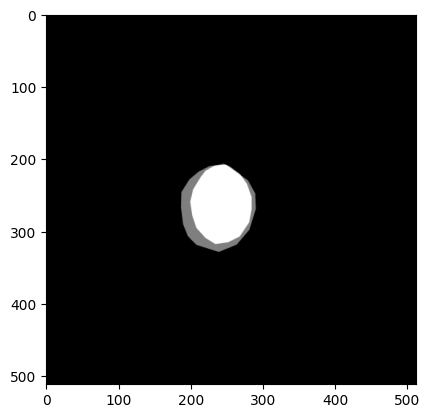

Normalized OD Area: 0.037567138671875


In [22]:
import cv2
import numpy as np

def compute_normalized_area_optic_disc(masked_image_path):

    try:

        masked_image_path = 'optic-disc' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

# Compute normalized area
normalized_area = compute_normalized_area_optic_disc(data['fundus_od_seg'][12044])

viewOpticDisc(data['fundus_od_seg'][12044])

print(f"Normalized OD Area: {normalized_area}")

In [23]:
data[["fundus", "fundus_oc_seg", "fundus_od_seg"]].describe()

,fundus,fundus_oc_seg,fundus_od_seg
count,12449,3103,3103
unique,12449,2875,3103
top,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,Not Visible,/optic-disc/ORIGA-1.png
freq,1,229,1


In [24]:
data = data[data['fundus_oc_seg'] != 'Not Visible']

In [25]:
data[["fundus", "fundus_oc_seg", "fundus_od_seg"]].describe()

,fundus,fundus_oc_seg,fundus_od_seg
count,12220,2874,2874
unique,12220,2874,2874
top,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png
freq,1,1,1


In [26]:
#removing the patients with no fundus classification and with fundus classification -1 instead of 0,1
data = data [

    (data['fundus'].notnull()) &
    (data['fundus_oc_seg'].notnull()) & 
    (data['fundus_od_seg'].notnull()) & (data['types'] != -1)
]

fundus_subset = data[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2805 entries, 4546 to 12048
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   types          2805 non-null   object
 1   fundus         2805 non-null   object
 2   fundus_oc_seg  2805 non-null   object
 3   fundus_od_seg  2805 non-null   object
 4   names          2805 non-null   object
 5   combined       2805 non-null   object
dtypes: object(6)
memory usage: 153.4+ KB


/tmp/ipykernel_29498/2187337796.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_29498/2187337796.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_29498/2187337796.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [27]:
import cv2
import numpy as np
import pandas as pd

data['OC size'] = 0.0

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_cup(row['fundus_oc_seg'])
    data.at[index, 'OC size'] = normalized_area

optic-cup/optic-cup/ORIGA-1.png
optic-cup/optic-cup/ORIGA-2.png
optic-cup/optic-cup/ORIGA-3.png
optic-cup/optic-cup/ORIGA-4.png
optic-cup/optic-cup/ORIGA-5.png
optic-cup/optic-cup/ORIGA-6.png
optic-cup/optic-cup/ORIGA-7.png


optic-cup/optic-cup/ORIGA-8.png
optic-cup/optic-cup/ORIGA-9.png
optic-cup/optic-cup/ORIGA-10.png
optic-cup/optic-cup/ORIGA-11.png
optic-cup/optic-cup/ORIGA-12.png
optic-cup/optic-cup/ORIGA-13.png
optic-cup/optic-cup/ORIGA-14.png
optic-cup/optic-cup/ORIGA-15.png
optic-cup/optic-cup/ORIGA-16.png
optic-cup/optic-cup/ORIGA-17.png
optic-cup/optic-cup/ORIGA-18.png
optic-cup/optic-cup/ORIGA-19.png
optic-cup/optic-cup/ORIGA-20.png
optic-cup/optic-cup/ORIGA-21.png
optic-cup/optic-cup/ORIGA-22.png
optic-cup/optic-cup/ORIGA-23.png
optic-cup/optic-cup/ORIGA-24.png
optic-cup/optic-cup/ORIGA-25.png
optic-cup/optic-cup/ORIGA-26.png
optic-cup/optic-cup/ORIGA-27.png
optic-cup/optic-cup/ORIGA-28.png
optic-cup/optic-cup/ORIGA-29.png
optic-cup/optic-cup/ORIGA-30.png
optic-cup/optic-cup/ORIGA-31.png
optic-cup/optic-cup/ORIGA-32.png
optic-cup/optic-cup/ORIGA-33.png
optic-cup/optic-cup/ORIGA-34.png
optic-cup/optic-cup/ORIGA-35.png
optic-cup/optic-cup/ORIGA-36.png
optic-cup/optic-cup/ORIGA-37.png
optic-cup/op

In [28]:
import cv2
import numpy as np
import pandas as pd

data['OD size'] = 0.0  

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_disc(row['fundus_od_seg'])
    data.at[index, 'OD size'] = normalized_area

optic-disc/optic-disc/ORIGA-1.png
optic-disc/optic-disc/ORIGA-2.png


optic-disc/optic-disc/ORIGA-3.png
optic-disc/optic-disc/ORIGA-4.png
optic-disc/optic-disc/ORIGA-5.png
optic-disc/optic-disc/ORIGA-6.png
optic-disc/optic-disc/ORIGA-7.png
optic-disc/optic-disc/ORIGA-8.png
optic-disc/optic-disc/ORIGA-9.png
optic-disc/optic-disc/ORIGA-10.png
optic-disc/optic-disc/ORIGA-11.png
optic-disc/optic-disc/ORIGA-12.png
optic-disc/optic-disc/ORIGA-13.png
optic-disc/optic-disc/ORIGA-14.png
optic-disc/optic-disc/ORIGA-15.png
optic-disc/optic-disc/ORIGA-16.png
optic-disc/optic-disc/ORIGA-17.png
optic-disc/optic-disc/ORIGA-18.png
optic-disc/optic-disc/ORIGA-19.png
optic-disc/optic-disc/ORIGA-20.png
optic-disc/optic-disc/ORIGA-21.png
optic-disc/optic-disc/ORIGA-22.png
optic-disc/optic-disc/ORIGA-23.png
optic-disc/optic-disc/ORIGA-24.png
optic-disc/optic-disc/ORIGA-25.png
optic-disc/optic-disc/ORIGA-26.png
optic-disc/optic-disc/ORIGA-27.png
optic-disc/optic-disc/ORIGA-28.png
optic-disc/optic-disc/ORIGA-29.png
optic-disc/optic-disc/ORIGA-30.png
optic-disc/optic-disc/ORIGA

In [29]:
data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect,OC size,OD size
4546,0.0,1.0,1.0,39.48,0,200.09,81.46,63.86,12.84,0.709700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010849,0.022560
4547,0.0,1.0,1.0,60.01,1,126.85,81.24,64.11,13.19,0.695300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010250,0.020405
4548,0.0,1.0,1.0,49.85,1,243.62,81.45,63.78,13.22,0.962900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019222,0.020947
4549,0.0,1.0,1.0,35.04,0,214.29,81.53,63.87,12.84,0.724600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008072,0.015347
4550,0.0,1.0,1.0,47.97,1,140.67,81.63,66.83,13.32,0.613800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,0.018131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,0.0,1.0,0.0,64.00,1,138.99,80.15,67.04,13.30,0.413448,...,-1.5,93,1,10,,531,22.31,,0.004856,0.037567
12045,0.0,1.0,1.0,75.00,1,155.35,79.07,56.59,14.83,0.647293,...,-0.25,160,1,19,,573,22.01,,0.004936,0.039188
12046,0.0,1.0,0.0,55.00,1,147.62,80.26,66.34,19.36,0.545931,...,-1.25,76,0,14,,443,23.51,,0.002399,0.024658
12047,0.0,1.0,1.0,56.00,1,155.10,81.57,67.47,13.52,0.541556,...,-0.75,79,0,9,,479,23.84,,0.006138,0.028481


In [30]:
fundus_subset['types'].value_counts()

types
0.0    2140
1.0     665
Name: count, dtype: int64

In [31]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
4546,0.0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
4547,0.0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,ORIGA-2.png
4548,0.0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,ORIGA-3.png
4549,0.0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,ORIGA-4.png
4550,0.0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,ORIGA-5.png
...,...,...,...,...,...,...
12044,0.0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,PAPILA-484.png
12045,0.0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,PAPILA-485.png
12046,0.0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,PAPILA-486.png
12047,0.0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,PAPILA-487.png


In [136]:
fundus_subset.describe()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
count,2805,2805,2805,2805,2805,2805
unique,2,2805,2805,2805,2805,2805
top,0.0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
freq,2140,1,1,1,1,1


In [137]:
# from sklearn.model_selection import StratifiedShuffleSplit

# Calculate the number of samples for each class
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1.0'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0.0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

# Set the percentages for the test and validation splits
test_percentage = 0.15  # 20% of the data for testing
val_percentage_from_train = 0.05  # 10% of the remaining data after test split for validation

# # Assuming fundus_subset is your DataFrame and 'types' is the column with labels

# # Set the random seed for reproducibility
# random_state = 1

# # Create StratifiedShuffleSplit instance for test set with percentage
# stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

# for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
#     train_set_temp = fundus_subset.iloc[train_index]
#     test = fundus_subset.iloc[test_index]

# # Note: Adjusted validation split to calculate percentage from the remaining train set
# # Create StratifiedShuffleSplit instance for validation set with percentage
# stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

# for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
#     train = train_set_temp.iloc[train_index]
#     val = train_set_temp.iloc[val_index]

# # Print the counts for each set and total
# print("\nTotal fundus images to be used:", len(fundus_subset))
# print("\nTrain set size:", len(train))
# print("Validation set size:", len(val))
# print("Test set size:", len(test))

# # You can access the features and labels as needed
# train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
# train_labels = train['types']
# val_features = val.drop('types', axis=1)
# val_labels = val['types']
# test_features = test.drop('types', axis=1)
# test_labels = test['types']

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

# Calculate class weights for the 'types' column
class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(fundus_subset['types']),
                y=fundus_subset['types'].values)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Set the random seed for reproducibility
random_state = 1

# Create StratifiedShuffleSplit instance for test set with percentage
stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

# Create StratifiedShuffleSplit instance for validation set with percentage
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

# Print the counts for each set and total
print("\nTotal fundus images to be used:", len(fundus_subset))
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

# Print class weights
print("\nClass weights for model training:")
print(class_weights_dict)

# You can access the features and labels as needed
# Example, assuming 'image' is the feature column and 'types' is the label column
train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140

Total fundus images to be used: 2805
Train set size: 2264
Validation set size: 120
Test set size: 421

Class weights for model training:
{0: 0.655373831775701, 1: 2.1090225563909772}


In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.utils import class_weight

# test_percentage = 0.20
# val_percentage_from_train = 0.10

# class_weights = class_weight.compute_class_weight(
#                 class_weight='balanced',
#                 classes=np.unique(fundus_subset['types']),
#                 y=fundus_subset['types'].values)

# class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# random_state = 1

# stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

# for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
#     train_set_temp = fundus_subset.iloc[train_index]
#     test = fundus_subset.iloc[test_index]

# stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

# for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
#     train = train_set_temp.iloc[train_index]
#     val = train_set_temp.iloc[val_index]

# train_features = train.drop('types', axis=1)
# train_labels = train['types']
# val_features = val.drop('types', axis=1)
# val_labels = val['types']
# test_features = test.drop('types', axis=1)
# test_labels = test['types']

In [138]:
test[["types"]].value_counts()

types
0.0      321
1.0      100
Name: count, dtype: int64

In [139]:
train[["types"]].value_counts()

types
0.0      1727
1.0       537
Name: count, dtype: int64

In [140]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  2264
Test Size:  421


In [141]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [142]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


# Set target size and batch size for data generator
target = 224
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2264 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 421 validated image filenames belonging to 2 classes.


In [143]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2264 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 421 validated image filenames belonging to 2 classes.


In [144]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2264 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 421 validated image filenames belonging to 2 classes.


In [145]:
# randomize data
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# create df for each class based on randomized data
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0.0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1.0']

with tf.device('/GPU:0'):

    # Set class mode to 'sparse' for visualization data generators
    classes = 'sparse'

    # Create data generators for healthy and glaucoma subsets for visualization
    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = healthy_subsetDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 2140 validated image filenames belonging to 1 classes.
Found 665 validated image filenames belonging to 1 classes.


In [146]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

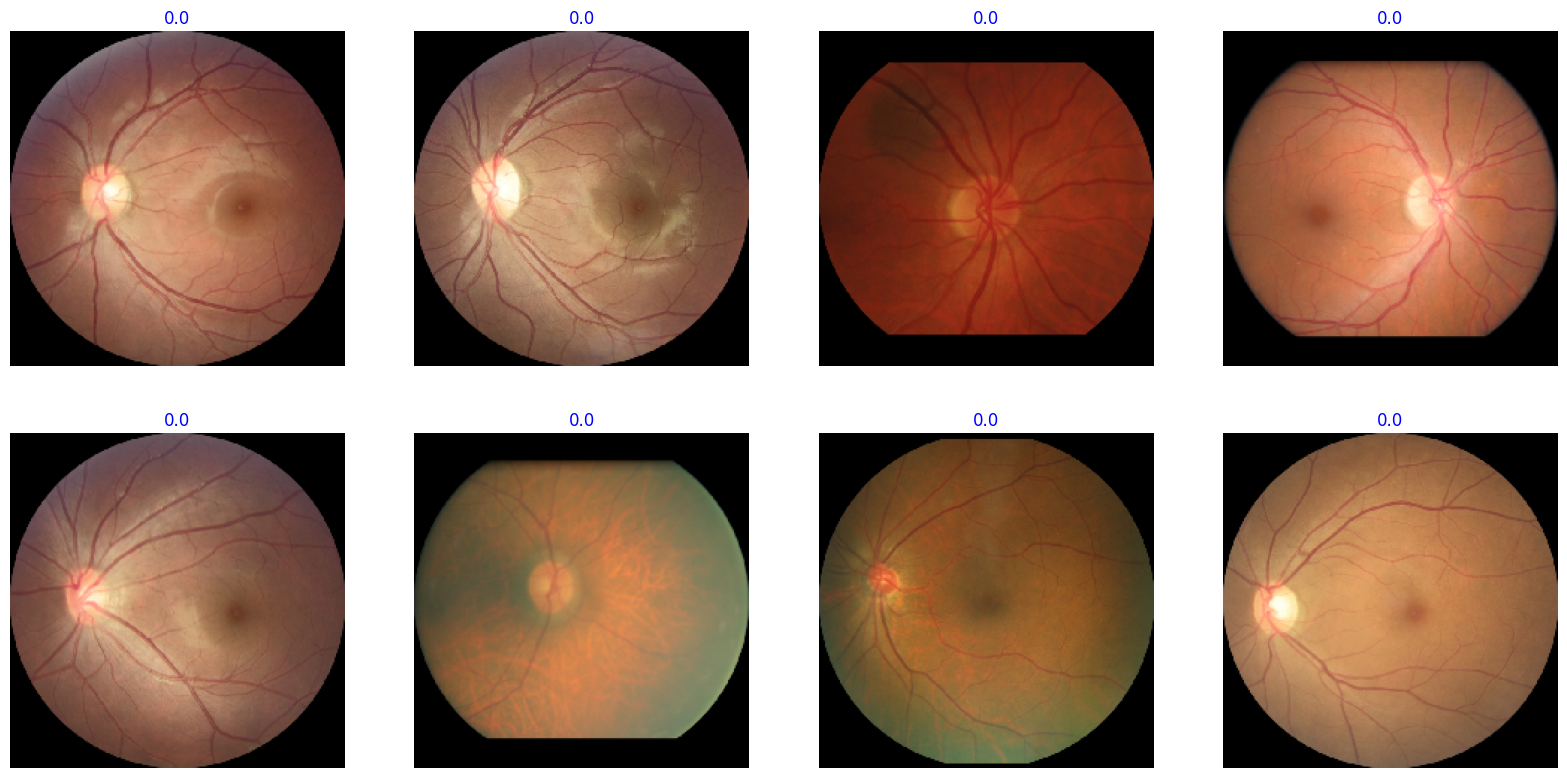

In [147]:
show_images(healthy_subset_Gen)

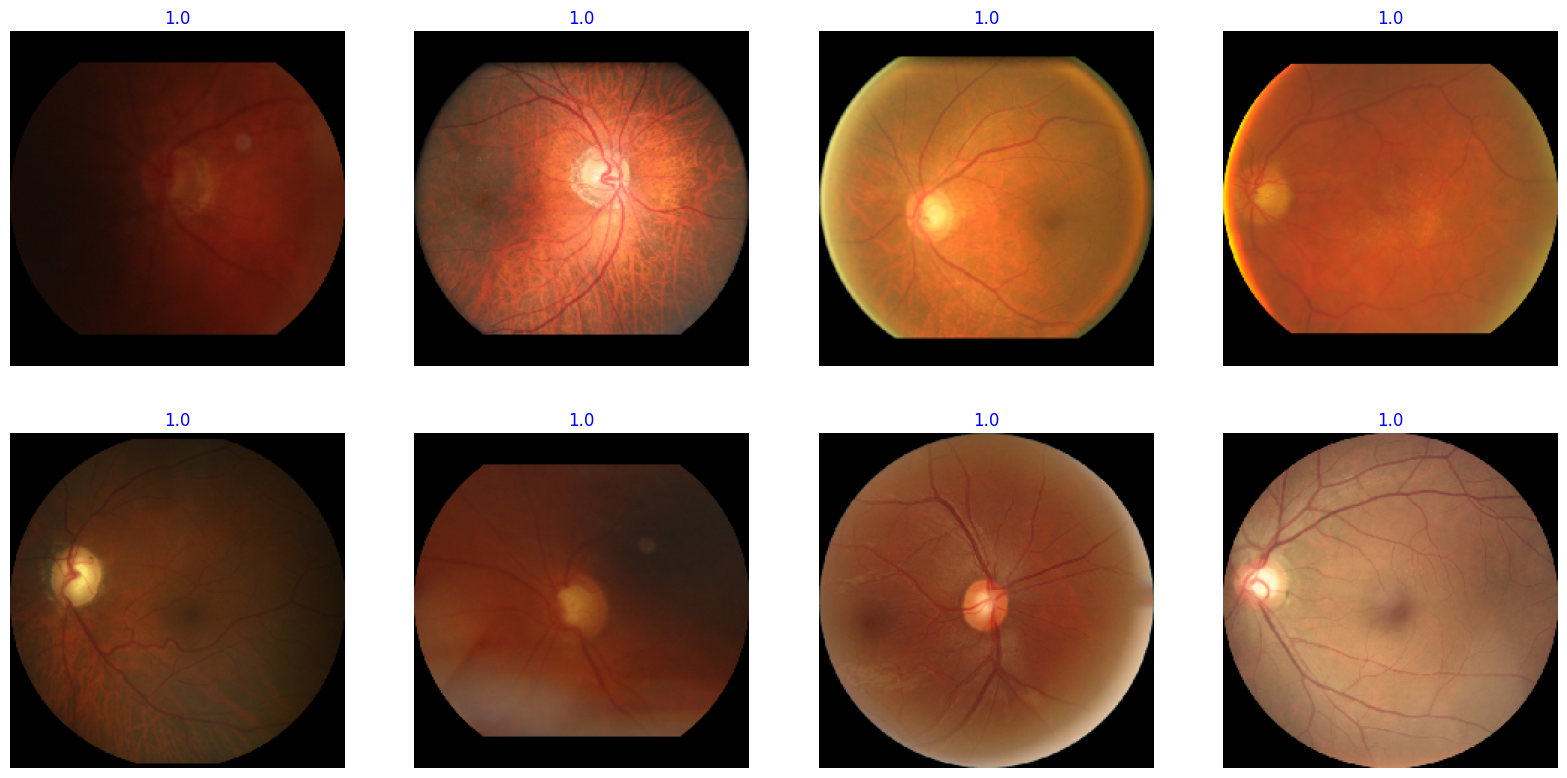

In [148]:
show_images(glaucoma_subset_Gen)

In [149]:
from keras.applications import MobileNetV3Small
from keras import Sequential

# Load pre-trained MobileNetV3 model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

# Function to extract features using this model
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [150]:
# from keras.applications import InceptionV3
# from keras import Sequential
# from keras.layers import GlobalAveragePooling2D
# import numpy as np

# # Load pre-trained InceptionV3 model
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(target, target, 3))

# # Assemble the sequential model with GlobalAveragePooling
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D()
# ])

# def extract_features(generator, sample_count, batchSize):
#     # Initialize a zeros array for features and labels
#     features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
#     labels = np.zeros(shape=(sample_count))
#     i = 0
#     # Loop over the data generator
#     for inputs_batch, labels_batch in generator:
#         features_batch = model.predict(inputs_batch)
#         batch_size = inputs_batch.shape[0]  # Get the actual batch size of the inputs
#         # If the total number of samples processed + current batch size is greater than sample_count,
#         # adjust the batch_size to fit what's remaining
#         # This happens on the last batch if sample_count isn't a multiple of batchSize
#         if (i * batchSize + batch_size) > sample_count:
#             batch_size = sample_count - (i * batchSize)
#         features[i * batchSize: i * batchSize + batch_size] = features_batch[:batch_size]
#         labels[i * batchSize: i * batchSize + batch_size] = labels_batch[:batch_size]
#         i += 1
#         if i * batchSize >= sample_count:
#             break
#     return features, labels


In [151]:
import numpy as np

# Select the non-image features from your dataframe
non_image_features = data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']]

# Extract image features as you've done before
train_features1, train_labels1 = extract_features(trainGen1, trainGen1.samples)
val_features1, val_labels1 = extract_features(valGen1, valGen1.samples)
test_features1, test_labels1 = extract_features(testGen1, testGen1.samples)

# Extract image features as you've done before for the optic cup pictures
train_features2, train_labels2 = extract_features(trainGen2, trainGen2.samples)
val_features2, val_labels2 = extract_features(valGen2, valGen2.samples)
test_features2, test_labels2 = extract_features(testGen2, testGen2.samples)

# Extract image features as you've done before for the optic disc pictures
train_features3, train_labels3 = extract_features(trainGen3, trainGen3.samples)
val_features3, val_labels3 = extract_features(valGen3, valGen3.samples)
test_features3, test_labels3 = extract_features(testGen3, testGen3.samples)


# Define a function to concatenate features from different sources
def combine_all_features(features_list, non_image_data, indices):

    # Concatenate all image features horizontally (axis=1)
    combined_features = np.concatenate(features_list, axis=1)
    
    # Retrieve the non-image features using the provided indices
    non_image_features = non_image_data.iloc[indices].to_numpy()
    
    # Concatenate the non-image features
    combined_features = np.concatenate((combined_features, non_image_features), axis=1)
    
    return combined_features


# Combine features for the training set
train_features_combined = combine_all_features(
    [train_features1, train_features2, train_features3],
    non_image_features,
    trainGen1.index_array  # Assuming the indices for image features correspond to the non-image data
)

# Combine features for the validation set
val_features_combined = combine_all_features(
    [val_features1, val_features2, val_features3],
    non_image_features,
    valGen1.index_array  # Make sure these indices correspond as well
)

# Combine features for the test set
test_features_combined = combine_all_features(
    [test_features1, test_features2, test_features3],
    non_image_features,
    testGen1.index_array  # And these indices
)

# Labels are assumed to be the same for all three image sets, so just take one set of labels
train_labels = train_labels1
val_labels = val_labels1
test_labels = test_labels1


1/1 [==============================] - 0s 21ms/step


In [152]:
train_features_combined

array([[ 1.79650992e-01,  2.68228650e+00,  5.02076268e-01, ...,
         7.51475000e-01,  5.39779663e-03,  1.53045654e-02],
       [ 2.90968828e-02,  1.16354549e+00,  1.69444770e-01, ...,
         7.43900000e-01,  3.86810303e-03,  1.80664062e-02],
       [-1.76769886e-02,  5.90790272e+00,  3.94547492e-01, ...,
         7.51475000e-01,  3.86810303e-03,  1.59072876e-02],
       ...,
       [ 8.53789747e-01,  2.39885497e+00,  9.46218669e-01, ...,
         7.37500000e-01,  1.74293518e-02,  2.48069763e-02],
       [-3.89482677e-02,  2.36073542e+00,  4.88930672e-01, ...,
         7.51475000e-01,  2.50244141e-03,  1.25846863e-02],
       [ 5.32770641e-02,  2.54261947e+00, -4.72555831e-02, ...,
         7.51475000e-01,  4.68826294e-03,  1.64451599e-02]])

In [153]:
from sklearn.svm import SVC

with tf.device('/GPU:0'):

    # Create and train the SVM
    svm_model = SVC(kernel='linear', probability=True, class_weight=class_weights_dict)
    svm_model.fit(train_features_combined, train_labels)

In [154]:
# Validate the SVM
val_accuracy = svm_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the SVM
test_accuracy = svm_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7166666666666667
Test accuracy: 0.7007125890736342


In [155]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = svm_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[239  82]
 [ 44  56]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.74      0.79       321
         1.0       0.41      0.56      0.47       100

    accuracy                           0.70       421
   macro avg       0.63      0.65      0.63       421
weighted avg       0.74      0.70      0.72       421



In [156]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)
knn_model.fit(train_features_combined, train_labels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [157]:
# Validate the KNN
val_accuracy = knn_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the KNN
test_accuracy = knn_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7666666666666667
Test accuracy: 0.7197149643705463


In [158]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = knn_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[295  26]
 [ 92   8]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83       321
         1.0       0.24      0.08      0.12       100

    accuracy                           0.72       421
   macro avg       0.50      0.50      0.48       421
weighted avg       0.64      0.72      0.66       421



In [159]:
import xgboost as xgb

scale_pos_weight = class_weights_dict[0] / class_weights_dict[1]

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(train_features_combined, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [160]:
# Validate the xgb model
val_accuracy = xgb_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the xgb model
test_accuracy = xgb_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7916666666666666
Test accuracy: 0.7695961995249406


In [161]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = xgb_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[310  11]
 [ 86  14]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86       321
         1.0       0.56      0.14      0.22       100

    accuracy                           0.77       421
   macro avg       0.67      0.55      0.54       421
weighted avg       0.73      0.77      0.71       421



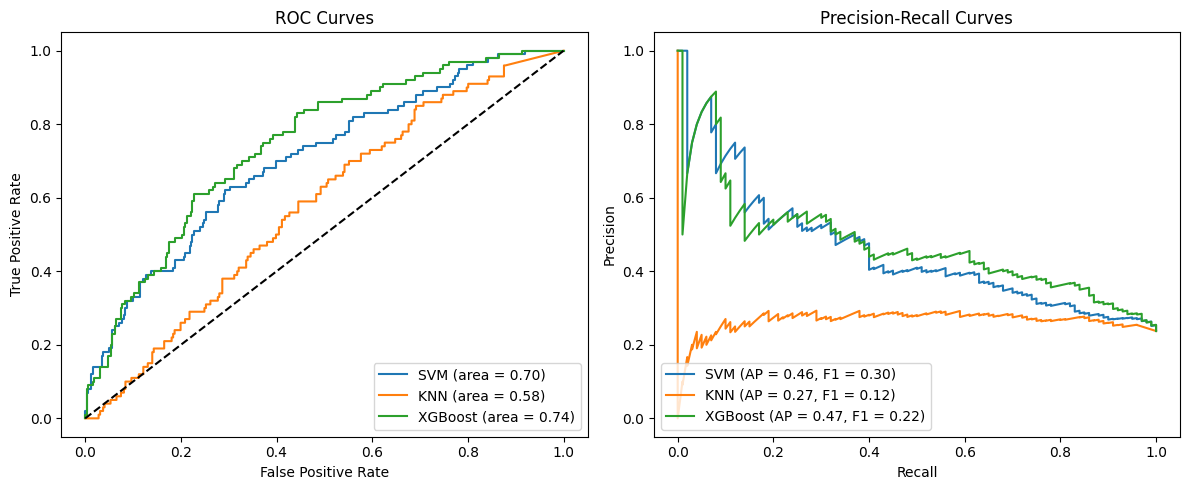

In [162]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

# Assuming you have the true labels and predicted probabilities for each model
true_labels = test_labels
svm_probs = svm_model.predict_proba(test_features_combined)[:, 1]

# KNN probabilities
knn_probs = knn_model.predict_proba(test_features_combined)[:, 1]

# XGBoost probabilities
xgb_probs = xgb_model.predict_proba(test_features_combined)[:, 1]

# Calculate ROC curve and ROC area for each model
fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate Precision-Recall curve and F1 score for each model
precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, svm_probs.round())

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, knn_probs.round())

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, xgb_probs.round())

# Plot all ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

# Plot all Precision-Recall curves
plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [163]:
# # Plot the confusion matrix heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.title('Confusion Matrix Heatmap')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

In [164]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# # define sequential model
# svm_model = Sequential()
# # define conv-pool layers - set 1
# svm_model.add(Conv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid', input_shape = (224, 224, 3)))
# svm_model.add(BatchNormalization(axis=3))
# svm_model.add(MaxPooling2D(pool_size=(2, 2)))


# # define conv-pool layers - set 2
# svm_model.add(Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid'))

# svm_model.add(MaxPooling2D(pool_size=(2, 2)))

# # define conv-pool layers - set 3
# svm_model.add(Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid'))
# svm_model.add(MaxPooling2D(pool_size=(2, 2)))


# # add flatten layer
# svm_model.add(Flatten())

# # add dense layers with some dropout
# svm_model.add(Dense(512, activation='relu'))
# svm_model.add(Dropout(rate = 0.2))
# svm_model.add(Dense(256, activation='relu'))
# svm_model.add(Dense(256, activation='relu'))
# svm_model.add(Dense(128, activation='relu'))

# # add output layer
# svm_model.add(Dense(1, kernel_regularizer = l2(0.01), activation='linear'))

# svm_model.summary()

In [165]:
# from keras.callbacks import TensorBoard, EarlyStopping
# from datetime import datetime

# logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [166]:
# from keras.backend import epsilon

# def f1_score_metric(y_true, y_pred):
#     y_pred = tf.round(y_pred)
#     return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + epsilon())

In [167]:
# with tf.device('/GPU:0'):

#     svm_model.compile(optimizer = 'adam',
#                 loss = 'squared_hinge',
#                 metrics=['accuracy','Precision','Recall','AUC',f1_score_metric])

#     r=svm_model.fit(trainGen,
#                 batch_size = 32,
#                 verbose = 1,
#                 epochs = 10,
#                 validation_data = valGen,
#                 callbacks = [tensorboard_callback, es],)

In [168]:
# # Evaluate the model on the validation data
# score=svm_model.evaluate(valGen)
# score

In [169]:
# # Plot the training and validation accuracy and loss
# import seaborn as sns
# sns.set()

# acc = r.history['accuracy']
# val_acc = r.history['val_accuracy']
# loss = r.history['loss']
# val_loss = r.history['val_loss']
# epochs = range(1, len(loss) + 1)

# #accuracy plot
# plt.plot(epochs, acc, color='green', label='Training Accuracy')
# plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()

# plt.figure()
# #loss plot
# plt.plot(epochs, loss, color='green', label='Training Loss')
# plt.plot(epochs, val_loss, color='red', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [170]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Generate predictions
# predictions = svm_model.predict(testGen)
# predictions = np.round(predictions).astype(int).flatten()  # Adjust based on your output format

# # Get true labels
# true_labels = testGen.labels

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predictions)
# print(f"Accuracy: {accuracy}")

# # Generate and print confusion matrix
# conf_matrix = confusion_matrix(true_labels, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate and print classification report
# class_report = classification_report(true_labels, predictions)
# print("Classification Report:")
# print(class_report)